# LifeSnaps NON Target Imputed Data Model
Aquest model de predicció agafa unicament els valors registrats tant en el TRAIN com en el TEST. Per tant no es fa imputacio de dades.

### Import de llibreries i warnings

In [11]:
# Exploració de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessament de dades
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Analisis del model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

In [12]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset cleaned

In [13]:
df = pd.read_csv('../data/df_cleaned.csv')
pd.set_option('display.max_columns', None)

display(df.head())
df.info()


,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,daily_temperature_variation,calories,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,resting_hr,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,RESTED/RELAXED,TENSE/ANXIOUS
0,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,-2.462709,2332.08,70.579300,132.0,25.0,31.0,704.0,62.121476,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0,<30,MALE,<19,0.0,0.0
1,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,-2.385801,2262.30,71.842573,112.0,27.0,31.0,710.0,62.263999,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0,<30,MALE,<19,0.0,0.0
2,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,-2.124199,2325.10,71.725477,133.0,21.0,37.0,622.0,62.368900,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0,<30,MALE,<19,0.0,0.0
3,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,-2.396873,2586.76,74.401028,136.0,42.0,54.0,647.0,61.965409,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0,<30,MALE,<19,0.0,0.0
4,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,-2.638646,3806.02,83.739770,305.0,128.0,98.0,371.0,62.671748,0.0,471.0,67.0,6.0,95.0,0.846154,0.870130,1.110294,1.170455,25526.0,428.0,986.0,2.0,0.0,<30,MALE,<19,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          2290 non-null   object 
 1   nightly_temperature           1717 non-null   float64
 2   nremhr                        1179 non-null   float64
 3   rmssd                         1179 non-null   float64
 4   spo2                          706 non-null    float64
 5   full_sleep_breathing_rate     1193 non-null   float64
 6   stress_score                  1041 non-null   float64
 7   sleep_points_percentage       1041 non-null   float64
 8   daily_temperature_variation   1699 non-null   float64
 9   calories                      2243 non-null   float64
 10  bpm                           2067 non-null   float64
 11  lightly_active_minutes        2243 non-null   float64
 12  moderately_active_minutes     2243 non-null   float64
 13  ver

## Preprocessament de dades

In [ ]:
# Definim els targets
TARGETS = ['TENSE/ANXIOUS', 'RESTED/RELAXED']
DATE = ['date']

y = df[TARGETS]
X = df.drop(columns=TARGETS + DATE)

print(y.info())
print(X.info())

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_cols = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

print(f"Nº variables numéricas: {len(numeric_cols)}")
print(f"Nº variables categóricas: {len(categoric_cols)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TENSE/ANXIOUS   2290 non-null   float64
 1   RESTED/RELAXED  2290 non-null   float64
dtypes: float64(2)
memory usage: 35.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nightly_temperature           1717 non-null   float64
 1   nremhr                        1179 non-null   float64
 2   rmssd                         1179 non-null   float64
 3   spo2                          706 non-null    float64
 4   full_sleep_breathing_rate     1193 non-null   float64
 5   stress_score                  1041 non-null   float64
 6   sleep_points_percentage       1041 non-null   float64
 7   daily_temperature_variati

In [15]:
# Transformem les columnes amb pipeline

numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())])

categoric_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_X),
    ("cat", categoric_pipe, categoric_X)
])

display(preprocessor)



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['nightly_temperature', 'nremhr', 'rmssd',
                                  'spo2', 'full_sleep_breathing_rate',
                                  'stress_score', 'sleep_points_percentage',
                                  'daily_temperature_variation', 'calories',
                                  'bpm', 'lightly_active_minutes',
                                  'moderately_active_minutes',
                                  'ver...
                                  'sleep_deep_ratio', 'sleep_wake_ratio',
                                  'sleep_light_ratio', 'sleep_rem_ratio',
                                  'steps', 'minutes_in_default_zone_1',
                                  'minutes_below_default_zone_1',
                                  'minutes_in_default_zone_2',
                                  'minutes_in_default_zone_3',
                                  'RESTED/RELAXED']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['date', 'age', 'gender', 'bmi'])])

In [16]:
# Dividim el dataset en train i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Comprovem com es visualitzaria el dataset despres del pipeline
# numéricas
num_imputer   = SimpleImputer(strategy="median")
X_num_imp     = pd.DataFrame(
    num_imputer.fit_transform(X_train[numeric_X]),
    columns=numeric_X,
    index=X_train.index
)

# categóricas
cat_imputer   = SimpleImputer(strategy="most_frequent")
X_cat_imp     = pd.DataFrame(
    cat_imputer.fit_transform(X_train[categoric_X]),
    columns=categoric_X,
    index=X_train.index
)

X_train_imp = pd.concat([X_num_imp, X_cat_imp], axis=1)
display(X_train_imp.head(20))

print(f'Files: {X_train_imp.shape[0]} \nColumnes: {X_train_imp.shape[1]} \n \n{X_train_imp.isnull().sum()/df.shape[0]*100}')


,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,daily_temperature_variation,calories,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,resting_hr,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,RESTED/RELAXED,date,age,gender,bmi
690,33.971263,61.720,35.274,95.9,14.5,76.0,0.766667,-1.440833,2059.20,78.379465,0.0,0.0,0.0,1440.0,65.485315,0.0,400.0,55.0,0.0,95.0,0.986486,0.960784,0.985075,0.989796,7857.0,135.0,1132.5,1.0,0.0,0.0,2021-12-07,<30,MALE,>=30
1997,33.971263,61.720,35.274,95.9,14.5,76.0,0.766667,-1.440833,2337.42,78.379465,197.0,13.0,9.0,748.0,65.485315,0.0,400.0,55.0,0.0,95.0,0.986486,0.960784,0.985075,0.989796,7857.0,135.0,1132.5,1.0,0.0,0.0,2021-05-22,>=30,MALE,24.0
1774,33.971263,61.720,35.274,95.9,14.5,76.0,0.766667,-1.440833,1857.60,96.200000,0.0,0.0,0.0,1440.0,65.485315,0.0,400.0,55.0,0.0,95.0,0.986486,0.960784,0.985075,0.989796,7857.0,1.0,0.0,0.0,0.0,0.0,2021-12-27,>=30,MALE,25.0
1483,34.586418,61.720,35.274,95.9,14.5,76.0,0.766667,-3.131154,2226.23,78.633773,433.0,7.0,39.0,562.0,65.190772,0.0,370.0,29.0,0.0,95.0,0.905882,0.500000,0.844156,1.113636,14692.0,237.0,1194.0,9.0,0.0,1.0,2021-06-05,>=30,FEMALE,19.0
1209,33.669810,69.011,25.734,95.9,15.0,85.0,0.766667,-0.725702,3523.92,96.134354,342.0,17.0,66.0,805.0,77.577152,0.0,188.0,22.0,0.0,97.0,0.698630,0.448980,0.497436,0.493827,15762.0,786.0,630.0,23.0,0.0,0.0,2021-06-29,>=30,MALE,23.0
430,34.320883,61.720,35.274,95.9,14.5,76.0,0.766667,-0.061673,3088.74,89.189283,226.0,33.0,41.0,823.0,69.563808,0.0,284.0,33.0,0.0,95.0,0.947368,0.733333,0.646018,0.865979,7690.0,208.0,1213.0,19.0,0.0,0.0,2021-07-14,>=30,MALE,22.0
1963,33.654443,58.456,56.876,95.9,13.0,76.0,0.766667,-0.520471,2109.03,69.005641,134.0,8.0,4.0,900.0,62.150351,0.0,323.0,71.0,0.0,90.0,1.106061,1.543478,1.297468,0.725806,4414.0,17.0,985.0,0.0,0.0,1.0,2021-07-09,<30,MALE,22.0
517,34.021733,61.720,35.274,95.9,14.5,76.0,0.766667,-2.641725,2530.09,82.077188,279.0,3.0,12.0,536.0,73.720474,0.0,531.0,79.0,1.0,96.0,1.421053,1.385965,1.248996,0.875000,8930.0,125.0,1307.0,8.0,0.0,0.0,2021-11-30,<30,FEMALE,>=25
1840,34.704457,61.720,35.274,95.9,14.5,76.0,0.766667,-0.590808,2154.29,78.285606,211.0,3.0,20.0,847.0,65.325850,0.0,315.0,44.0,0.0,96.0,0.454545,0.771930,0.894068,0.958333,7330.0,193.0,1188.0,0.0,0.0,0.0,2021-05-26,>=30,FEMALE,24.0
375,32.857309,61.629,26.094,96.8,14.0,75.0,0.666667,-2.607029,1622.50,80.206075,173.0,0.0,0.0,875.0,68.769298,0.0,334.0,58.0,0.0,94.0,1.111111,0.983051,0.792308,0.537037,4005.0,171.0,1052.0,46.0,14.0,0.0,2022-01-11,>=30,FEMALE,20.0


Files: 1832 
Columnes: 34 
 
nightly_temperature             0.0
nremhr                          0.0
rmssd                           0.0
spo2                            0.0
full_sleep_breathing_rate       0.0
stress_score                    0.0
sleep_points_percentage         0.0
daily_temperature_variation     0.0
calories                        0.0
bpm                             0.0
lightly_active_minutes          0.0
moderately_active_minutes       0.0
very_active_minutes             0.0
sedentary_minutes               0.0
resting_hr                      0.0
minutesToFallAsleep             0.0
minutesAsleep                   0.0
minutesAwake                    0.0
minutesAfterWakeup              0.0
sleep_efficiency                0.0
sleep_deep_ratio                0.0
sleep_wake_ratio                0.0
sleep_light_ratio               0.0
sleep_rem_ratio                 0.0
steps                           0.0
minutes_in_default_zone_1       0.0
minutes_below_default_zone_1    0.0

In [17]:
# Definim els models que provarem de utilitzar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', max_depth=None),
    "SVC": SVC(kernel="rbf", random_state=42, probability=True, class_weight='balanced')
}


resultats = {}

# Definim el cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nom, model in models.items():
    # Creem el pipeline
    clf = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])

    # Avaluem el model amb cross-validation
    puntuacio = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

    # Mostrem els resultats
    resultats[nom] = puntuacio.mean()
    print(f"{nom} | Mitjana Cross Validation ROC-AUC {puntuacio.mean():.3f} ± {puntuacio.std():.3f}")

Logistic Regression | Mitjana Cross Validation ROC-AUC 0.597 ± 0.027
Random Forest | Mitjana Cross Validation ROC-AUC 0.649 ± 0.015
SVC | Mitjana Cross Validation ROC-AUC 0.628 ± 0.010


Millor model: Random Forest


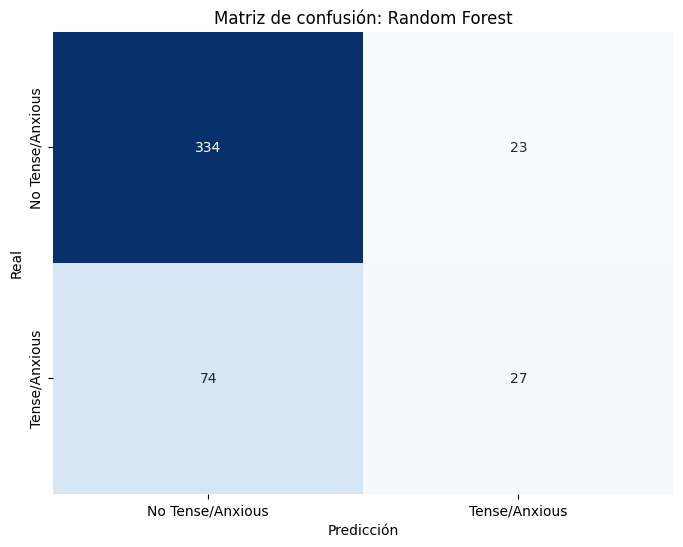


Classification report:
               precision    recall  f1-score   support

         0.0      0.819     0.936     0.873       357
         1.0      0.540     0.267     0.358       101

    accuracy                          0.788       458
   macro avg      0.679     0.601     0.615       458
weighted avg      0.757     0.788     0.760       458

Test ROC‑AUC: 0.691


In [18]:
# Escollim el millor resultat per avaluar el model

millor_model = max(resultats, key=resultats.get)
print(f"Millor model: {millor_model}")

millor_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", models[millor_model])
])

millor_pipeline.fit(X_train, y_train)

y_pred = millor_pipeline.predict(X_test)
y_proba = millor_pipeline.predict_proba(X_test)[:, 1]

matriu_confusio=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matriu_confusio, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Tense/Anxious', 'Tense/Anxious'], yticklabels=['No Tense/Anxious', 'Tense/Anxious'])
set_title= plt.title(f'Matriz de confusión: {millor_model}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
print(f"Test ROC‑AUC: {roc_auc_score(y_test, y_proba):.3f}")




